# Cellpose Segmentation and Seeding Efficiency Assignment

## A - Google Colab Environemnt Dependencies

In [ ]:
# Install necessary packages
!pip install -q scikit-image matplotlib cellpose

In [ ]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

## B - Project Dependencies

In [1]:
# Load packages
from skimage.measure import regionprops, label
from skimage.io import imread
import numpy as np
import pandas as pd
import cv2
from cellpose import models

In [3]:
# Access Project folder:
projectPath = '/content/drive/My Drive/Colab Notebooks/LifeAnalytics/EVIDENT/'

## C - Pre-processing

Generating Stacked frames into TIF (Only one execution needed)

In [ ]:
# ONLY NEEDED TO RUN ONCE
"""
from PIL import Image
import os

# Set your image folder
image_folder = projectPath+'/CM30'
images = sorted([f for f in os.listdir(image_folder) if f.endswith('.jpg')])

# Open images and convert to grayscale or RGB
pil_images = [Image.open(os.path.join(image_folder, img)).convert("L") for img in images]

# Save as multi-frame .tif
output_path = projectPath+'/media/CM30.tif'
pil_images[0].save(output_path, save_all=True, append_images=pil_images[1:])
"""

## I - Cells Segmentation

### 1. Load the Image Data

In [4]:
image_stack = imread(projectPath+'media/CM30.tif')
n_frames, height, width = image_stack.shape             # shape: (frames, height, width)

### 2. Initialize Cellpose4 Model

In [ ]:
model = models.CellposeModel(gpu=True)

### 3. Segment Cells in Each Frame

In [ ]:
results = []

for i, frame in enumerate(image_stack):
    masks, flows, styles = model.eval(frame, diameter=None, flow_threshold=None, cellprob_threshold=-0.8)
    results.append({'masks': masks, 'flows': flows, 'image': frame})

  * Save results as a pickle file for later use

In [5]:
import pickle

# Save for later use
"""
with open(projectPath+'results/segmentation/segmentation_results.pkl', 'wb') as f:
    pickle.dump(results, f)
"""

# Load when needed
with open(projectPath+'results/segmentation/segmentation_results.pkl', 'rb') as f:
    results = pickle.load(f)

  * Save results as .npz for later use

In [ ]:
# Save for later use
"""
all_masks = [r['masks'] for r in results]
all_flows = [r['flows'][0] for r in results]  # optional
all_frames = [r['image'] for r in results]

np.savez(projectPath+'results/segmentation/segmentation_data.npz', masks=all_masks, flows=all_flows, frames=all_frames)
"""

# Load when needed
"""
data = np.load(projectPath+'results/segmentation/segmentation_data.npz', allow_pickle=True)
masks = data['masks']
flows = data['flows']
frames = data['frames']
"""

  * Plot results for Frame 0

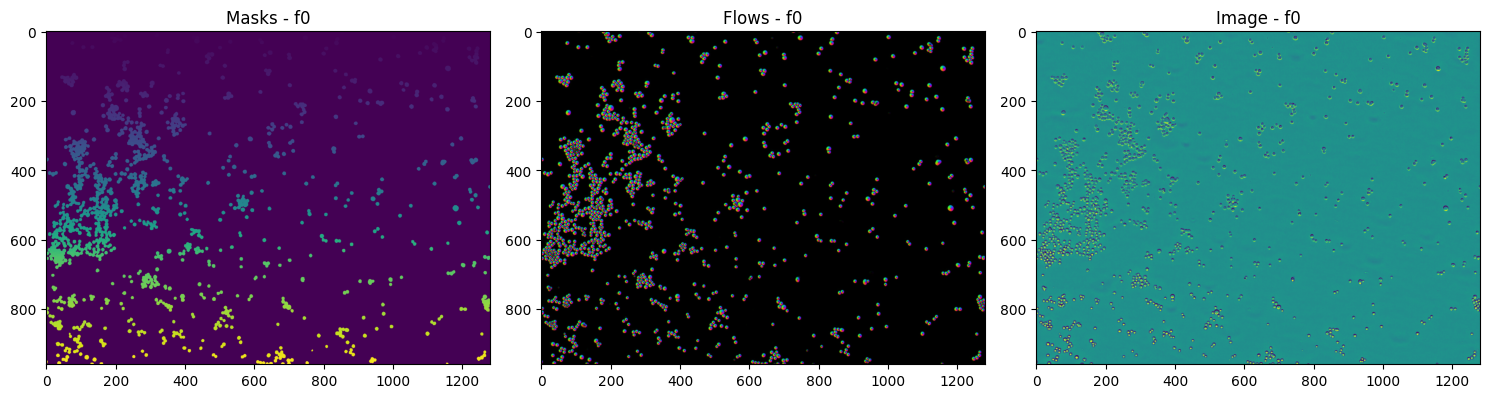

In [7]:
import matplotlib.pyplot as plt

# Frame 0 Example: Create a 3x1 grid of subplots
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 15))

# Masks
axes[0].imshow(results[0]['masks'])
axes[0].set_title('Masks - f0')

# Flows
axes[1].imshow(results[0]['flows'][0])
axes[1].set_title('Flows - f0')

# Masks
axes[2].imshow(results[0]['image'])
axes[2].set_title('Image - f0')

plt.tight_layout() # Adjust subplot parameters for a tight layout
plt.show()

## II - Seeding Efficiency (Cells count and Fragmentation)

Frames are grouped as follow:

- Initial: 0 → n_frames // 3

- Fixed: n_frames // 3 → 2 * n_frames // 3

- Dead: 2 * n_frames // 3 → end

In [ ]:
cell_counts = []

for i, result in enumerate(results):
  masks = result['masks']
  image = result['image']
  labeled = label(masks)

  # ─── Cell-wise properties ───
  props = regionprops(labeled, intensity_image=image)
  areas = [p.area for p in props]
  brightness = [p.mean_intensity for p in props]

  num_cells = len(props)                                        # Number of cells in frame
  avg_area = np.mean(areas) if areas else 0                     # Mean area of cells in frame
  avg_brightness = np.mean(brightness) if brightness else 0     # Mean brightness of cells in frame


  # ─── Fragments detection ───
  # Determine state based on frame index
  if i < n_frames // 3:
      state = 'Circular'
  elif i < 2 * n_frames // 3:
      state = 'Fixed'
  else:
      state = 'Dead'

  circular = fixed = dead = 0
  fragment_classes = [0, 0, 0, 0]  # cls0, cls1, cls2, cls3

  for p in props:
    area = p.area
    ecc = p.eccentricity
    sol = p.solidity

    # New fragment classification logic
    if area < 40 and ecc > 0.9:
        cls = 0  # apoptotic
    elif sol < 0.75:
        cls = 1  # necrotic
    elif ecc > 0.9:
        cls = 2  # fixed
    else:
        cls = 3  # regular round

    fragment_classes[cls] += 1

    # Count major phase cells (optional – may be dropped if you're fragment-focused)
    if cls == 3:  # assume "regular" are the main viable cells
        if state == 'Circular':
            circular += 1
        elif state == 'Fixed':
            fixed += 1
        elif state == 'Dead':
            dead += 1

  cell_counts.append({
      'Frame': i,
      'num_cells': num_cells,
      'Circular': circular,
      'Fixed': fixed,
      'Dead': dead,
      'fragments': sum(fragment_classes[0:3]),
      'apoptotic': fragment_classes[0],
      'necrotic': fragment_classes[1],
      'fixed': fragment_classes[2],
      'regular': fragment_classes[3],
      'avg_area': avg_area,
      'avg_brightness': avg_brightness
  })

# Convert to DataFrame
seeding_efficiency = pd.DataFrame(cell_counts)

* Save "cell_counts.csv" for later use

In [27]:
# Save to CSV
seeding_efficiency.to_csv(projectPath+'results/seeding_efficiency/cell_counts.csv', index=False)

# Load to DataFrame
#seeding_efficiency = pd.read_csv(projectPath+'results/seeding_efficiency/cell_counts.csv')

## III - Generate AVI Files
* a. Segmentation with 4-Class Fragment Mask Colors (Apoptotic, Necrotic, Fixed, Regular)
* b. Segmentation with 3-Phase Segments (Circular, Fixed, Dead)
* C. AVI with Overlay of Masks Outlines + Original Image

In [ ]:
from skimage.measure import find_contours

# Output video parameters
fourcc = cv2.VideoWriter_fourcc(*'XVID')
fps = 3
size = (width, height)

# Color definitions (BGR)
class_colors = [  # For morphology-based classification
    (230, 25, 75),    # Class 0: Apoptotic - Red
    (67, 99, 216),    # Class 1: Necrotic  - Blue
    (60, 180, 75),    # Class 2: Fixed     - Green
    (245, 130, 48),   # Class 3: Regular   - Orange
]

phase_colors = {  # For phase segmentation
    'Circular': (0, 255, 255),   # Yellow
    'Fixed':    (255, 255, 0),   # Cyan
    'Dead':     (255, 0, 255),   # Magenta
}

# Initialize video writers
video_segmentation = cv2.VideoWriter(projectPath + 'results/seeding_efficiency/fragments_segmentation.avi',
                                     fourcc, fps, size)
video_overlay = cv2.VideoWriter(projectPath + 'results/seeding_efficiency/overlay.avi',
                                fourcc, fps, size)
video_phase = cv2.VideoWriter(projectPath + 'results/seeding_efficiency/phase_segmentation.avi',
                              fourcc, fps, size)

for i, result in enumerate(results):
  print(i)
  masks = result['masks']
  image = result['image']
  labeled = label(masks)
  props = regionprops(labeled, intensity_image=image)

  # 1. Blank image for segmentation (by class)
  vis_seg = np.zeros((height, width, 3), dtype=np.uint8)

  # 2. Overlay: original grayscale + class-colored mask outlines
  if image.ndim == 2:
      img_rgb = np.stack([image] * 3, axis=-1)
  else:
      img_rgb = image.copy()

  img_rgb = (img_rgb / img_rgb.max() * 255).astype(np.uint8)
  vis_overlay = img_rgb.copy()

  # 3. Blank image for phase segmentation
  vis_phase = np.zeros((height, width, 3), dtype=np.uint8)

  # Determine phase based on frame index
  if i < n_frames // 3:
      phase = 'Circular'
  elif i < 2 * n_frames // 3:
      phase = 'Fixed'
  else:
      phase = 'Dead'

  phase_color = phase_colors[phase]

  for p in props:
      area = p.area
      ecc = p.eccentricity
      sol = p.solidity

      # --- Morphology-based classification ---
      if area < 40 and ecc > 0.9:
          cls = 0  # Apoptotic
      elif sol < 0.75:
          cls = 1  # Necrotic
      elif ecc > 0.9:
          cls = 2  # Fixed
      else:
          cls = 3  # Regular

      mask = np.zeros_like(masks, dtype=np.uint8)
      mask[tuple(p.coords.T)] = 255
      contours = find_contours(mask, 0.5)

      for contour in contours:
          contour = np.flip(contour, axis=1).astype(np.int32)

          # Draw on segmentation video (by class)
          cv2.drawContours(vis_seg, [contour], -1, class_colors[cls], 1)

          # Draw on overlay (original + class mask outline)
          cv2.drawContours(vis_overlay, [contour], -1, class_colors[cls], 1)

          # Draw on phase segmentation video
          cv2.drawContours(vis_phase, [contour], -1, phase_color, 1)

  # Write each frame
  video_segmentation.write(vis_seg)
  video_overlay.write(vis_overlay)
  video_phase.write(vis_phase)

# Release all videos
video_segmentation.release()
video_overlay.release()
video_phase.release()